# Import libraries

In [1]:
# Import libraries
import os
import pandas as pd
import json
import sacrebleu

# Set Paths

In [2]:
# Base path
base_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))

# Model Parameters
unsloth_model_name = 'unsloth/gemma-2-9b-it-bnb-4bit'
company_name = 'alphabet'
model_name = unsloth_model_name.split('/')[1]

# Results path
results_path_file = os.path.join(base_path, 'results', company_name, model_name, 'merged_results.json')

# Print paths
print('Base path:', base_path)
print('Results path:', results_path_file)

Base path: /cs/student/msc/csml/2023/ngriessh/historical_mt
Results path: /cs/student/msc/csml/2023/ngriessh/historical_mt/results/alphabet/gemma-2-9b-it-bnb-4bit/merged_results.json


# Set Evaluation Parameters

In [11]:
# Choose source language
source_language = "English"
target_language = "English" if source_language == "Early Modern Bohemian German" else "Early Modern Bohemian German"

# Evaluate finetuning and icl?
evaluate_icl = True
evaluate_finetuning = False

# Median splitting with regard to word count?
median_splitting = False
# Translation direction is defined depending on the chosen source languag 
translation_direction = "DE_to_EN" if source_language == "Early Modern Bohemian German" else "EN_to_DE"

# Print
print(f'Source Language: {source_language}')
print(f'Target Language: {target_language}')
print(f'Translation Direction: {translation_direction}')
print(f'Evaluate ICL: {evaluate_icl}')
print(f'Evaluate finetuning: {evaluate_finetuning}')
print(f'Median Splitting? {median_splitting}')

Source Language: English
Target Language: Early Modern Bohemian German
Translation Direction: EN_to_DE
Evaluate ICL: True
Evaluate finetuning: False
Median Splitting? False


# Load Results File

In [12]:
# Load the JSON file
with open(results_path_file, 'r') as f:
    data = [json.loads(line) for line in f]

# Create a DataFrame based on the JSON file
merged_df = pd.DataFrame(data)

# Check Columns

In [13]:
# Check column names
merged_df.columns

Index(['Early Modern Bohemian German', 'English',
       'DE_to_EN_000_example_prompt', 'DE_to_EN_001_example_prompt',
       'DE_to_EN_002_example_prompt', 'DE_to_EN_004_example_prompt',
       'EN_to_DE_000_example_prompt', 'EN_to_DE_001_example_prompt',
       'EN_to_DE_002_example_prompt', 'EN_to_DE_004_example_prompt'],
      dtype='object')

# Construct Candidate Columns

In [14]:
# Define a function to generate candidate columns based on the conditions
def construct_candidate_columns(translation_direction, evaluate_icl, evaluate_finetuning):
    shots = ['000', '001', '002', '004'] #, '008', '016', '032', '064', '128']
    
    # Add shots columns
    if evaluate_icl:
        if translation_direction == 'DE_to_EN':
            candidate_columns = [f'DE_to_EN_{shot}_example_prompt' for shot in shots]
        elif translation_direction == 'EN_to_DE':
            candidate_columns = [f'EN_to_DE_{shot}_example_prompt' for shot in shots]
    
    # Add finetuning column
    if evaluate_finetuning:
        if evaluate_icl:
            candidate_columns.append(f'{translation_direction}_finetuning')
        else:
            candidate_columns = [f'{translation_direction}_finetuning']
    
    return candidate_columns

# You can now concatenate or use these columns as needed
candidate_columns = construct_candidate_columns(translation_direction, evaluate_icl, evaluate_finetuning)
candidate_columns

['EN_to_DE_000_example_prompt',
 'EN_to_DE_001_example_prompt',
 'EN_to_DE_002_example_prompt',
 'EN_to_DE_004_example_prompt']

# Median Splitting

In [15]:
# Compute word count for the source_language column
source_language_word_count = f'{source_language}_word_count'
merged_df[source_language_word_count] = merged_df[source_language].apply(lambda x: len(str(x).split()))

# Compute the median word count
median_word_count = merged_df[source_language_word_count].median()

# Create merged_df_short and merged_df_long based on the median
merged_df_short = merged_df[merged_df[source_language_word_count] <= median_word_count]
merged_df_long = merged_df[merged_df[source_language_word_count] > median_word_count]

#vPrint the shapes of the datasets
print("Shape of merged_df_short:", merged_df_short.shape)
print("Shape of merged_df_long:", merged_df_long.shape)
print(f'Median word count in {source_language}: {median_word_count}')

Shape of merged_df_short: (506, 11)
Shape of merged_df_long: (494, 11)
Median word count in English: 80.0


In [16]:
merged_df_short.head()

,Early Modern Bohemian German,English,DE_to_EN_000_example_prompt,DE_to_EN_001_example_prompt,DE_to_EN_002_example_prompt,DE_to_EN_004_example_prompt,EN_to_DE_000_example_prompt,EN_to_DE_001_example_prompt,EN_to_DE_002_example_prompt,EN_to_DE_004_example_prompt,English_word_count
2,3. Novembris. Matz Apelt beschweret sich Vber ...,3. Novembris. Matz Apelt complains against Jac...,November 3rd. Matz Apelt complains about Jacob...,November 3rd. Matthias Apel complains about Ja...,3 November. Matthias Apel complains about Jaco...,3 November. Matz Apel complains about Jacob Sc...,Dritte Novēmberis. Matz Apel klagt wider Jakob...,Den 3.Novembres beschwert sich Matts Apelth wi...,Den 3.Novembres. Matts Apel klagt wider Jakob ...,3.Novembres. Matthäus Apel klagte wider Jakob ...,77
3,"Adam Kötter von d. Wittige, demnach er sich mi...","Adam Koetter from the Wittige, since he disput...","Adam Kötter von der Wittege, inasmuch as he hi...","Adam Kötter von der Witte, inasmuch as he has ...","Adam Kötter from Wittig, because he quarreled ...","Adam Kötter von d. Wittig, since he quarreled ...","Adam Kötter von dem Witige, ob er mit Worten u...","Adame Kötter aus dem Witige, weil er mit Ursel...","Adam Kötter vom Witige, denn er im Wort und wi...","Adam Kötter vom wittigen, demnach er mit Worte...",67
4,Adam Krauß zumb Einsiedel saget auff sein gewi...,Adam Krauss in Einsiedel declares on his consc...,Adam Krauss of Einsidtel says on his certain k...,"Adam Krauss of Einsidil says on his word, want...","Adam Krauss of Einsidil says upon his word, wa...","Adam Krauss zum Einsidle says upon his word, w...",Adam Kraus zu Einsidl bekennt auf sein Gewisse...,Adams Kraus zu Einsidil wider sein Gewissen er...,Adam Kraus in Ensiedl erklärt auf sein Gewisse...,Adam krauß in einsiedal erklärt auff sei Gewis...,70
10,Demnach Ihme vom Ampt Aufferleget vnd befohlen...,After he was instructed and commanded by the m...,Therefore he having been assigned by order and...,Therefore him by order given and commanded tha...,According to him by order given and commanded ...,Since he has been assigned by the manor and or...,Nach er ward von dem obrigkeitlichen Gericht b...,Nach dem Er hat durchs Gericht zu der Herrscha...,Nachdem ihm vom herrschaftlichem Gericht befoh...,Nachdem er vom Ambt gelehret und befehligt war...,58
11,Demnach sie der Seligern von der Frau Johrmizi...,After she spoken badly to Seliger's wife/widow...,Therefore she spoke about the Blessed Virgin M...,Therefore it was spoken by the blessed one abo...,Since she spoke ill about the Blessed Virgin M...,Since she spoke ill about the blessed one by n...,Nachdem sie schlecht geredet hat zu Seligers W...,Nach dem sie schlecht geredet hat zu Seligers ...,Nach dem sie schlecht geredet hatte wider Seli...,Nachdem sie schlecht geredet hat zur Seligers ...,45


In [17]:
merged_df_long.head()

,Early Modern Bohemian German,English,DE_to_EN_000_example_prompt,DE_to_EN_001_example_prompt,DE_to_EN_002_example_prompt,DE_to_EN_004_example_prompt,EN_to_DE_000_example_prompt,EN_to_DE_001_example_prompt,EN_to_DE_002_example_prompt,EN_to_DE_004_example_prompt,English_word_count
0,1. dz Sie verschienen freytag als den 29 huig ...,"1. last Friday, the 29th, they came up to the ...",If you appear on Friday as the 29th in great n...,"They appeared on Friday, the 29th, in large nu...",1. When they appeared Friday as the 29th in la...,1. When they appeared Friday as the 29th in la...,"Vergangene Freitag den XXIX., kamen sie zu ein...",Ersterlich zu wissen ist es so gewesen; letzte...,"1. Letzten Freitagm dem 29., kamen sie zahlrei...","1. Letzten Freitagm, dem 29., kamen sie zahlre...",435
1,Es ist Vor.12. iharen Vnnd mehr Zu Oberweigßdo...,"12 years ago and more, in Oberweigsdorf, Paul ...",It is before 12th [month] in their village mor...,It was before twelve years ago in Oberweigsdor...,It is before 12 o'clock here and more at Oberw...,Before twelve o’clock yesterday at Oberweigsdo...,Vor zwölff Jahren und mehr ist zu Oberweigsdor...,Vor zwölff Jahren und mehr zu Obernwegsdorff i...,Vor zwölff jahren und mehrn im oberweiggsdorff...,Vor 12 Jaren und mehr ist obir weiggsdorff pau...,105
5,Raspenaw. Adam Kulman Klagt Vber Paul Kelern V...,Adam Kulman complains against Paul Kelern from...,Adam Kulman complains about Paul KeIler from M...,Adam Kulman sues Paul KeIler from Mildeinaich ...,Raspenaw. Adam Kulman complains about Paul Kel...,RäspeNaw. Adam Kulmann complaints over Paul Ke...,Adam Kulman klagen widerst Paule Kelern aus Mi...,Adame Culmann klagt wider Paule Keleren aus Mi...,Adame Kulmann klagt wider Paule Keelen aus mil...,Adam kulmān beklagte sich über paul kelern aus...,443
6,Adam Seeliger Zu Mildenaich Claget Vber des al...,Adam Seeliger in Mildenaich complains against ...,Adam Seeliger Zu Mildenaich clages over old Th...,Adam Seeliger of Mildenai complains about old ...,Adam Seeliger of Mildenai complains about old ...,Adam Seeliger Zu Mildenaich claims over old Th...,Adam Seēligger zu Mildeinaich klagt wider den ...,Adame Seelyger zu Mildenaich klagt wider des a...,Adam Seheligier in mildaichen klagt wider des ...,Adam Seiliger in mildenaich klage wider alten ...,267
7,"Demnach hannß Tageman vom Einsidel, mit Anna B...",After Hannss Tageman from Einsidel lived in fo...,"Therefore Hans Tagesmann from Einsiedl, with A...",According to which Hans Tagesmann from Einsied...,"According to this, Hans Tagesmann from Einsied...","Since then Hannß Tagemann from Einsiedl, with ...",Nach dem dass Hans Tagesmann aus Enßidel mit d...,Nach dem dass der Hanss Tagesmann aus Ensiedl ...,Nach dem dass Hannss Tagemann von einsiedl mit...,Nach Hannss Tagemann vom Einsiedle lebte in Un...,173


# BLEU Evaluation

In [18]:
# Check if median splitting is true
if median_splitting:
    dataset_splits = [merged_df_short, merged_df_long]
    dataset_names = ['merged_df_short', 'merged_df_long']
else:
    dataset_splits = [merged_df]
    dataset_names = ['merged_df']

# Compute BLEU scores for both datasets
for split, name in zip(dataset_splits, dataset_names):
    # Print statement
    print('______________________________________________________________________________________________')
    print(f'Current Dataset: {name}. Source language is {source_language}.')
    print('______________________________________________________________________________________________')

    # Create references for split
    references = [split[target_language].tolist()]

    # Compute corpus-level BLEU scores
    for col in candidate_columns:
        candidates = split[col].tolist()
        print(f'Evaluation of target language {target_language} and LLM-generated candidates {col}')
        bleu_score = sacrebleu.corpus_bleu(candidates, references).score
        print(f"Corpus-level SacreBLEU score for {col}: {bleu_score:.3f}\n")

______________________________________________________________________________________________
Current Dataset: merged_df. Source language is English.
______________________________________________________________________________________________
Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_000_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_000_example_prompt: 1.193

Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_001_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_001_example_prompt: 1.002

Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_002_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_002_example_prompt: 1.154

Evaluation of target language Early Modern Bohemian German and LLM-generated candidates EN_to_DE_004_example_prompt
Corpus-level SacreBLEU score for EN_to_DE_004_example_prompt: 1.334



# Create Text File to Inspect Translation Results

In [19]:
# Function to generate the inspection text for a specific entry
def generate_inspection_text(df, entry_index, translation_directions, output_file):
    with open(output_file, 'w', encoding='utf-8') as f:

        # Get the row corresponding to the entry index
        row = df.iloc[entry_index]

        # Write the German and English translations pairs by Sheilagh Ogilvie
        f.write(f"Entry {entry_index + 1}:\n")
        f.write(f"Early Modern Bohemian German (Sheilagh Ogilvie's Transcription): {row['Early Modern Bohemian German']}\n")
        f.write(f"English (Sheilagh Ogilvie): {row['English']}\n\n")

        # Write the candidate translations for each translation direction
        for col in df.columns:
            if any(direction in col for direction in translation_directions):
                f.write(f"{col}: {row[col]}\n")
        
        f.write("\n" + "="*50 + "\n\n")

# Define the translation directions and the entry to inspect
translation_directions = ['DE_to_EN', 'EN_to_DE']
entry_index = 0

# Call the function to generate the text file
output_file = 'translation_inspection_entry.txt'
generate_inspection_text(merged_df, entry_index, translation_directions, output_file)
print(f"Text file created: {output_file}")


Text file created: translation_inspection_entry.txt


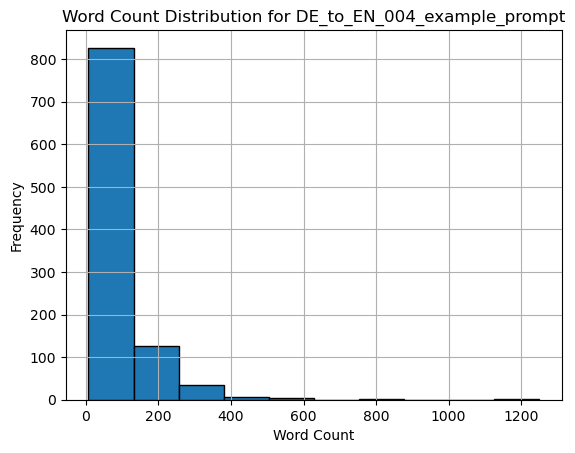

In [20]:
import matplotlib.pyplot as plt

# Function to compute word count and plot the histogram for any column
def plot_word_count_distribution(df, column_name):
    # Compute word count for each entry in the specified column
    df['word_count'] = df[column_name].apply(lambda x: len(x.split()))
    
    # Plotting the histogram of word count distribution
    plt.hist(df['word_count'], bins=10, edgecolor='black')
    plt.title(f'Word Count Distribution for {column_name}')
    plt.xlabel('Word Count')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Example usage with 'DE_to_EN_128_example_prompt'
plot_word_count_distribution(merged_df, 'DE_to_EN_004_example_prompt')